# Tests the Predictive Power of a Signal with paramaters like L-S Alpha, Informtion Coefficient, Factor Auto Correlation etc. Ideally a factor should have statistically significnat L-S ALpha, High IC and High Factor Correlation for low Strategy Turnover

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import warnings
from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils
from scipy import stats
import statsmodels.api as sm

# Load and apply custom filter on the Universe

In [12]:
#***********************This Section is to read from saved file and index*****************
concat_df=pd.read_csv('data/Data_Y_nifty500.csv')
#screen_data=pd.read_csv('data/Peer_Ticker_nifty1000_stand_cleaned.csv')
#screen_1=screen_data[screen_data['Debt / Eq'] < 0.33]
#screen_2=screen_1[screen_1['Prom. Hold.  %'] > 20]
#screen_3=screen_2[screen_2['ROE  %'] > 15]
#screen_3=screen_3[screen_3['ROA 12M  %'] > 10]
#screen_4=screen_2[screen_2['CMP  Rs.'] < 5000]
#screen_4=screen_4[screen_4['CMP  Rs.'] > 50]
#screen_4=screen_4['Ticker'].unique().tolist()
#len(screen_4)
#concat_df=concat_df[concat_df['Symbol'].isin(screen_4)]

In [13]:
concat_df.groupby('Capitalization')['Symbol'].apply(lambda x:len(x.unique().tolist()))

Capitalization
LARGE        73
MIDCAP      107
SMALLCAP    185
Name: Symbol, dtype: int64

# Treating missing values

In [14]:
column_list=['Share_Turnover','Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss', 'Mom_Slope',
       'Liquidity', 'Volatility', 'CAPM_Beta','CAPM_Alpha', 'Sales_Growth',
       'OPM_Growth', 'EPS_Growth', 'EPS', 'E/P', 'PEG','Size_Factor', 'StDev']
for column in column_list:
    concat_df[concat_df[column]==""] = np.NaN
    concat_df[column]=concat_df.groupby('Symbol')[column].fillna(method='bfill')
    concat_df[column]=concat_df.groupby('Symbol')[column].fillna(method='ffill')

# Winsorizing at 1% and 99% levels

In [15]:
column_list=['Share_Turnover','Return', 'Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss', 'Mom_Slope',
       'Liquidity', 'Volatility', 'CAPM_Beta','CAPM_Alpha', 'Sales_Growth',
       'OPM_Growth', 'EPS_Growth', 'EPS', 'E/P', 'PEG','Size_Factor', 'StDev']
for column in column_list:
    #concat_df[column]=concat_df.groupby('Date')[column].apply(lambda x:np.where(x > x.quantile(0.99),x.quantile(0.99), x))
    #concat_df[column]=concat_df.groupby('Date')[column].apply(lambda x:np.where(x > x.quantile(0.01),x.quantile(0.01), x))
    concat_df[column]=np.where(concat_df[column] > concat_df[column].quantile(0.99),concat_df[column].quantile(0.99), concat_df[column])
    concat_df[column]=np.where(concat_df[column] < concat_df[column].quantile(0.01),concat_df[column].quantile(0.01), concat_df[column])

# Scoring/ Ranking the factors to create Long Only Portoflios

In [16]:
column_list=['Share_Turnover','Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss', 'Mom_Slope',
       'Liquidity', 'Volatility', 'CAPM_Beta','CAPM_Alpha', 'Sales_Growth',
       'OPM_Growth', 'EPS_Growth', 'EPS', 'E/P', 'PEG','Size_Factor', 'StDev']
for column in column_list:
    concat_df[column]=concat_df.groupby('Date')[column].rank(ascending=1)

# Create Custom Factors by mixing them like Momentum_Value, Momentum_Std, Momentum_EP etc

In [17]:
concat_df['MomSharpe_Size_EP']=concat_df['Mom_Sharpe']+concat_df['Size_Factor']+concat_df['E/P']
concat_df['Mom_Size']=concat_df['Momentum']+concat_df['Size_Factor']
concat_df['MomSharpe_Size']=concat_df['Mom_Sharpe']+concat_df['Size_Factor']
concat_df['Mom_Std_Sales']=concat_df['Momentum']+concat_df['StDev']+concat_df['Sales_Growth']
concat_df['Mom_EP']=concat_df['Momentum']+concat_df['E/P']
concat_df['Size_EP']=concat_df['Size_Factor']+concat_df['E/P']
concat_df['Vol_Size_EP']=concat_df['Volatility']+concat_df['Size_Factor']+concat_df['E/P']
concat_df['Mom_Size_Sales']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']
concat_df['Mom_Size_Sales_Std']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['StDev']
concat_df['Mom_Size_Std']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['StDev']
concat_df['Size_Std']=concat_df['Size_Factor']+concat_df['StDev']
concat_df['Mom_Std']=concat_df['Momentum']+concat_df['StDev']
concat_df['Size_Sales_EP']=concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['E/P']

# Prepare data for Alphalens Package

In [18]:
concat_df.set_index(pd.DatetimeIndex(concat_df['Date']), append=False, inplace=True)
concat_df.index.tz_localize('UTC')
concat_df.set_index(['Symbol'], append=True, inplace=True)
concat_df=concat_df.reorder_levels(['Date', 'Symbol'])
concat_df.sort_index(inplace=True)
concat_df=concat_df.groupby(level=concat_df.index.names).last()
#concat_df.drop(['Date'])
concat_df.columns
concat_df=concat_df.drop(['Unnamed: 0', 'Date'], axis=1)
concat_df.columns

Index(['Company Name', 'Industry', 'Capitalization', 'Open', 'High', 'Low',
       'Close', 'Adj Close', 'Volume', 'Share_Turnover', 'Return', 'Momentum',
       'Mom_Sharpe', 'Mom_Gain_Loss', 'Mom_Slope', 'StDev', 'Liquidity',
       'Volatility', 'NSE500', 'CAPM_Beta', 'CAPM_Alpha', 'Sector_Return',
       'Sales', 'OPM', 'NetProfit', 'EPSinRs', 'DividendPayout',
       'OtherLiabilities', 'Open_Shares', 'Sales_Growth', 'EPS_Growth',
       'OPM_Growth', 'ROE', 'Leverage', 'BVPS', 'Sale_per_share', 'EPS in Rs',
       'EPS', 'E/P', 'Sales/Price', 'BV/Price', 'PEG', 'Div/Price',
       'Size_Factor', 'Quality', 'Value', 'MomSharpe_Size_EP', 'Mom_Size',
       'MomSharpe_Size', 'Mom_Std_Sales', 'Mom_EP', 'Size_EP', 'Vol_Size_EP',
       'Mom_Size_Sales', 'Mom_Size_Sales_Std', 'Mom_Size_Std', 'Size_Std',
       'Mom_Std', 'Size_Sales_EP'],
      dtype='object')

In [19]:
# Function to get Information Coefficient and related details 
def get_factor_information(factor_data, factor_name="factor_name"):
    ic_data=perf.factor_information_coefficient(merged_data, group_adjust=False,by_group=False)
    ic_summary_table = pd.DataFrame()
    ic_summary_table["IC Mean"] = ic_data.mean()
    ic_summary_table["IC Std."] = ic_data.std()
    ic_summary_table["Risk-Adjusted IC"] = ic_data.mean() / ic_data.std()
    t_stat, p_value = stats.ttest_1samp(ic_data, 0)
    ic_summary_table["t-stat(IC)"] = t_stat
    ic_summary_table["p-value(IC)"] = p_value
    ic_summary_table["IC Skew"] = stats.skew(ic_data)
    ic_summary_table["IC Kurtosis"] = stats.kurtosis(ic_data)
    ic_summary_table=ic_summary_table.T
    ic_summary_table["Factor_Data"] = factor_name
    ic_summary_table["Attribute"]="Factor_Information"
    return ic_summary_table

In [20]:
# Function to calculate long short Alpha and related details
def get_factor_returns(factor_data,factor_name="factor_name", long_short=True, group_neutral=False, by_group=False):  
    factor_returns = perf.factor_returns(factor_data, long_short, group_neutral)
    mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,by_group=False,demeaned=long_short,group_adjust=group_neutral,)
    mean_quant_rateret = mean_quant_ret.apply(utils.rate_of_return, axis=0, base_period=mean_quant_ret.columns[0])
    mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(factor_data,by_date=True,by_group=False,demeaned=long_short,group_adjust=group_neutral,)
    mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(utils.rate_of_return,axis=0,base_period=mean_quant_ret_bydate.columns[0],)
    compstd_quant_daily = std_quant_daily.apply(utils.std_conversion, axis=0, base_period=std_quant_daily.columns[0])
    alpha_beta = perf.factor_alpha_beta(factor_data, factor_returns, long_short, group_neutral)
    mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(mean_quant_rateret_bydate,factor_data["factor_quantile"].max(),factor_data["factor_quantile"].min(),std_err=compstd_quant_daily,)
    returns_table = pd.DataFrame()
    returns_table = returns_table.append(alpha_beta)
    returns_table.loc["Mean Period Wise Return Top Quantile (bps)"] = mean_quant_rateret.iloc[-1] * DECIMAL_TO_BPS
    returns_table.loc["Mean Period Wise Return Bottom Quantile (bps)"] = mean_quant_rateret.iloc[0] * DECIMAL_TO_BPS
    returns_table.loc["Mean Period Wise Spread (bps)"] = mean_ret_spread_quant.mean() * DECIMAL_TO_BPS
    #returns_table=returns_table.T
    returns_table["Factor_Data"]=factor_name
    returns_table["Attribute"]="Factor_Returns"
    return returns_table

In [21]:
DECIMAL_TO_BPS = 10000

In [22]:
# Function to get Factor Turnover and Decay
def get_factor_turnover(factor_data,factor_name="factor_name", turnover_periods=None):  
    if turnover_periods is None:
        input_periods = utils.get_forward_returns_columns(factor_data.columns, require_exact_day_multiple=True,).tolist()
        turnover_periods = utils.timedelta_strings_to_integers(input_periods)
    else:
        turnover_periods = utils.timedelta_strings_to_integers(turnover_periods,)
    quantile_factor = factor_data["factor_quantile"]

    quantile_turnover = {
        p: pd.concat(
            [
                perf.quantile_turnover(quantile_factor, q, p)
                for q in quantile_factor.sort_values().unique().tolist()
            ],
            axis=1,
        )
        for p in turnover_periods
    }
    autocorrelation = pd.concat(
        [
            perf.factor_rank_autocorrelation(factor_data, period)
            for period in turnover_periods
        ],
        axis=1,
    )
    turnover_table = pd.DataFrame()
    for period in sorted(quantile_turnover.keys()):
        for quantile, p_data in quantile_turnover[period].iteritems():
            turnover_table.loc["Quantile {} Mean Turnover ".format(quantile),
                               "{}D".format(period)] = p_data.mean()
    auto_corr = pd.DataFrame()
    for period, p_data in autocorrelation.iteritems():
        auto_corr.loc["Mean Factor Rank Autocorrelation",
                      "{}D".format(period)] = p_data.mean()
    #auto_corr.append(turnover_table)
    #auto_corr=auto_corr.T
    #turnover_table=turnover_table.T
    auto_corr["Factor_Data"]=factor_name
    auto_corr["Attribute"]="Factor_Turnover"
    turnover_table["Factor_Data"]=factor_name
    turnover_table["Attribute"]="Factor_Turnover"
    return auto_corr, turnover_table

In [23]:
# Select Factors to Test
factor_list=['Momentum', 'Mom_Sharpe', 'Mom_Slope',
       'StDev','ROE', 'E/P', 'Sales/Price', 'BV/Price',
       'Size_Factor', 'Quality', 'Value', 'MomSharpe_Size_EP','Vol_Size_EP',
       'Mom_Size','Mom_EP', 'Size_EP', 'Mom_Size_Std', 'Size_Std']
print(factor_list)

['Momentum', 'Mom_Sharpe', 'Mom_Slope', 'StDev', 'ROE', 'E/P', 'Sales/Price', 'BV/Price', 'Size_Factor', 'Quality', 'Value', 'MomSharpe_Size_EP', 'Vol_Size_EP', 'Mom_Size', 'Mom_EP', 'Size_EP', 'Mom_Size_Std', 'Size_Std']


In [24]:
# Format Pricing Data
price_data=pd.DataFrame(concat_df['Adj Close']).stack().unstack(level=1)
price_data.head()
price_data.index.name=None
price_data.index = price_data.index.droplevel(1)
price_data.head()
from alphalens.utils import get_clean_factor_and_forward_returns
#longest_look_forward_period = 90 # week = 5, month = 21, quarter = 63, year = 252
#range_step = 5

# Run Alpha Lens for Factor over various time periods like(5, 10, 20,66,130,250 days) and max_loss paramater

In [25]:
combined_df=pd.DataFrame()
#factor_information=pd.DataFrame()
count = 1 
for factor_name in factor_list:
    factor_data=pd.DataFrame(concat_df[factor_name])
    factor_data.index.name = ""
    merged_data = get_clean_factor_and_forward_returns(factor=factor_data,prices=price_data,periods = (5,10,20,66,130,250),max_loss=0.45)
    print("Running Alphalens for Factor: ",count, factor_name)
    factor_information=get_factor_information(merged_data,factor_name) 
    #print(factor_information.head())
    combined_df=combined_df.append(factor_information)
    #print("Running Factor Returns for Factor: ", factor_name)
    factor_returns=get_factor_returns(merged_data,factor_name)
    #print(factor_returns.head())
    combined_df=combined_df.append(factor_returns)
    #print("Running Factor Turnover for Factor: ", factor_name)
    factor_auto_corr, factor_turnover_table=get_factor_turnover(merged_data,factor_name)
    #print(factor_auto_corr.head())
    #print(factor_turnover_table.head())
    combined_df=combined_df.append(factor_auto_corr)
    combined_df=combined_df.append(factor_turnover_table)
    count=count + 1
combined_df.to_csv('data\Combined_Alpha_Factor.csv')
#factor_information.to_csv('Factor_Information.csv')

Dropped 12.9% entries from factor data: 12.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 45.0%, not exceeded: OK!
Running Alphalens for Factor:  1 Momentum
Dropped 12.9% entries from factor data: 12.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 45.0%, not exceeded: OK!
Running Alphalens for Factor:  2 Mom_Sharpe
Dropped 12.9% entries from factor data: 12.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 45.0%, not exceeded: OK!
Running Alphalens for Factor:  3 Mom_Slope
Dropped 12.9% entries from factor data: 12.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 45.0%, not exceeded: OK!
Running Alphalens for Factor:  4 StDev
Dropped 13.8% entries from factor da

In [31]:
combined_df=combined_df.reset_index()
combined_df[combined_df['Attribute']=='Factor_Information']

,index,5D,10D,20D,66D,130D,250D,Factor_Data,Attribute
0,IC Mean,3.157262e-02,4.221687e-02,5.611209e-02,8.557671e-02,9.409673e-02,7.518670e-02,Momentum,Factor_Information
1,IC Std.,1.328412e-01,1.418008e-01,1.498255e-01,1.493323e-01,1.576632e-01,1.559844e-01,Momentum,Factor_Information
2,Risk-Adjusted IC,2.376719e-01,2.977194e-01,3.745164e-01,5.730622e-01,5.968212e-01,4.820143e-01,Momentum,Factor_Information
3,t-stat(IC),1.050069e+01,1.315368e+01,1.654668e+01,2.531872e+01,2.636842e+01,2.129609e+01,Momentum,Factor_Information
4,p-value(IC),3.956330e-25,6.334780e-38,1.188971e-57,1.578987e-122,2.564048e-131,1.175387e-90,Momentum,Factor_Information
...,...,...,...,...,...,...,...,...,...
308,Risk-Adjusted IC,1.685579e-01,2.552355e-01,3.636775e-01,8.149200e-01,1.365009e+00,2.328093e+00,Size_Std,Factor_Information
309,t-stat(IC),7.447133e+00,1.127667e+01,1.606780e+01,3.600434e+01,6.030808e+01,1.028585e+02,Size_Std,Factor_Information
310,p-value(IC),1.424082e-13,1.286785e-28,1.177382e-54,4.073892e-218,0.000000e+00,0.000000e+00,Size_Std,Factor_Information
311,IC Skew,-1.096055e-01,-1.205709e-01,-1.630919e-01,1.516576e-01,9.630126e-03,3.605430e-01,Size_Std,Factor_Information


# Function to calculate between Factor Correlation

In [32]:
import scipy.cluster.hierarchy as spc
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

def plot_corr(df,size=10):
    # Compute the correlation matrix for the received dataframe
    dist = pdist(df.corr().values)
    linkage = spc.linkage(dist, method='complete')
    idx = spc.fcluster(linkage, 0.5 * dist.min(), 'distance')
    columns = [df.columns.tolist()[i] for i in list((np.argsort(idx)))]
    #corr = df.reindex_axis(columns, axis=1).corr()
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [33]:
factor_return=pd.read_csv('data/Factor_Return.csv')
factor_return.columns

Index(['Date', 'Plot_Momentum', 'Plot_Mom_Sharpe', 'Plot_Mom_Slope',
       'Plot_StDev', 'Plot_ROE', 'Plot_E/P', 'Plot_Sales/Price',
       'Plot_BV/Price', 'Plot_Size_Factor', 'Plot_Quality', 'Plot_Value',
       'Plot_MomSharpe_Size_EP', 'Plot_Vol_Size_EP', 'Plot_Mom_Size',
       'Plot_Mom_EP', 'Plot_Size_EP', 'Plot_Mom_Size_Std', 'Plot_Size_Std'],
      dtype='object')

In [34]:
f1=factor_return[['Plot_Momentum', 'Plot_Mom_Sharpe', 'Plot_Mom_Slope',
       'Plot_StDev', 'Plot_ROE', 'Plot_E/P', 'Plot_Sales/Price',
       'Plot_BV/Price', 'Plot_Size_Factor', 'Plot_Quality', 'Plot_Value',
       'Plot_MomSharpe_Size_EP', 'Plot_Vol_Size_EP', 'Plot_Mom_Size',
       'Plot_Mom_EP', 'Plot_Size_EP', 'Plot_Mom_Size_Std', 'Plot_Size_Std']]

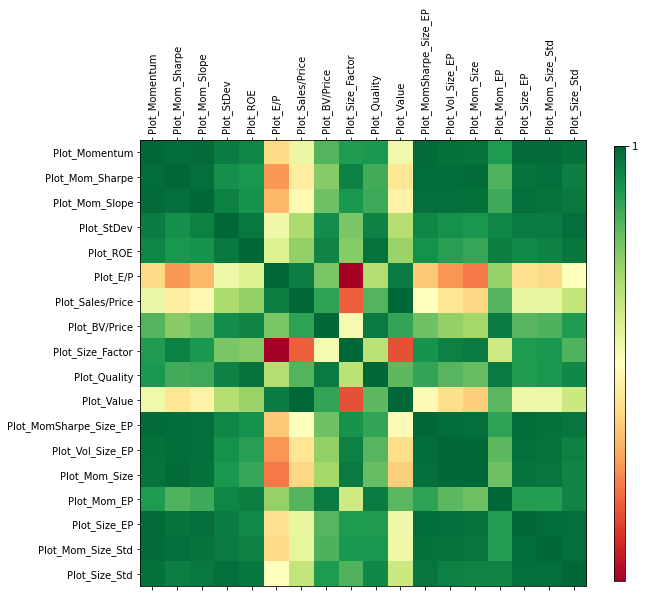

In [35]:
# Plot Factor Correlation
plot_corr(factor_return)

In [36]:
factor_return.corr()

,Plot_Momentum,Plot_Mom_Sharpe,Plot_Mom_Slope,Plot_StDev,Plot_ROE,Plot_E/P,Plot_Sales/Price,Plot_BV/Price,Plot_Size_Factor,Plot_Quality,Plot_Value,Plot_MomSharpe_Size_EP,Plot_Vol_Size_EP,Plot_Mom_Size,Plot_Mom_EP,Plot_Size_EP,Plot_Mom_Size_Std,Plot_Size_Std
Plot_Momentum,1.000000,0.988368,0.990766,0.962208,0.942878,0.476218,0.613335,0.845490,0.903173,0.910862,0.598167,0.992776,0.981401,0.977669,0.907621,0.991878,0.990171,0.982229
Plot_Mom_Sharpe,0.988368,1.000000,0.985396,0.928674,0.913947,0.365479,0.513712,0.780986,0.951353,0.865101,0.497691,0.988162,0.988726,0.990140,0.848555,0.978511,0.985564,0.958719
Plot_Mom_Slope,0.990766,0.985396,1.000000,0.953485,0.919980,0.413371,0.548918,0.814843,0.910919,0.874595,0.532188,0.984535,0.984569,0.980244,0.871603,0.983561,0.978991,0.968807
Plot_StDev,0.962208,0.928674,0.953485,1.000000,0.967975,0.601543,0.727225,0.930164,0.798180,0.952608,0.713898,0.944927,0.922508,0.915170,0.944621,0.961561,0.964996,0.985537
Plot_ROE,0.942878,0.913947,0.919980,0.967975,1.000000,0.640476,0.766502,0.946363,0.782662,0.979270,0.756020,0.924791,0.897954,0.878974,0.959086,0.939005,0.951251,0.971995
Plot_E/P,0.476218,0.365479,0.413371,0.601543,0.640476,1.000000,0.957668,0.797873,0.135230,0.718832,0.960944,0.441574,0.363540,0.326927,0.760307,0.488156,0.476297,0.567586
Plot_Sales/Price,0.613335,0.513712,0.548918,0.727225,0.766502,0.957668,1.000000,0.889901,0.287397,0.844632,0.999702,0.569009,0.498168,0.469590,0.846280,0.619772,0.618750,0.691344
Plot_BV/Price,0.845490,0.780986,0.814843,0.930164,0.946363,0.797873,0.889901,1.000000,0.587946,0.963642,0.883066,0.811890,0.765255,0.740082,0.965697,0.844536,0.853330,0.906874
Plot_Size_Factor,0.903173,0.951353,0.910919,0.798180,0.782662,0.135230,0.287397,0.587946,1.000000,0.702981,0.269731,0.921994,0.955327,0.963981,0.669554,0.908237,0.911639,0.850930
Plot_Quality,0.910862,0.865101,0.874595,0.952608,0.979270,0.718832,0.844632,0.963642,0.702981,1.000000,0.835779,0.883595,0.842949,0.824440,0.965060,0.903008,0.912694,0.941705
